# **NOTEBOOK 1:**
## Diabetes Prevalence Metro/non-Metro Areas in 2017

**Source:** https://www.ruralhealthinfo.org/charts/37

This notebook will explore the data in the file containing information about each county's diabetes prevalence in 2017 and type of county (metropolitan or non-metropolitan) information.

The goal is to see which counties have the greatest diabetes prevalence in this year and if that changes based on county type.

After cleaning and adjusting the data set, I will make some initial observations that will be useful for data exploration in the subsequent notebooks.

### Set up data

In [119]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.simplefilter('ignore')

### Load and inspect the data

In [120]:
#import large diabetes file with county data for 2017
diabetes2017_df = pd.read_csv('../data/diabetes_prevalence.csv')

In [121]:
#what is the shape of the data frame?
nrows, ncols = diabetes2017_df.shape

print(f'Data frame has {nrows} rows and {ncols} columns.')

Data frame has 3145 rows and 5 columns.


In [122]:
#What columns does this data inlcude?
print(diabetes2017_df.columns)

Index(['metro_nonmetro', 'county_name', 'state_abbr', 'geoId', 'value'], dtype='object')


In [123]:
#what kind of observations were made for each variable?
diabetes2017_df.sample(20)

,metro_nonmetro,county_name,state_abbr,geoId,value
576,Metropolitan,Polk County,MO,us-mo-167,0.104000
2989,Nonmetropolitan,Lee County,VA,us-va-105,0.132006
3069,Nonmetropolitan,Marquette County,WI,us-wi-077,0.135002
1609,Nonmetropolitan,Franklin County,IL,us-il-055,0.148002
1437,Nonmetropolitan,Jeff Davis County,GA,us-ga-161,0.202017
2948,Nonmetropolitan,Emery County,UT,us-ut-015,0.118009
1085,Metropolitan,Radford City,VA,us-va-750,0.086003
2727,Nonmetropolitan,Decatur County,TN,us-tn-039,0.154016
84,Metropolitan,San Joaquin County,CA,us-ca-077,0.103000
3044,Nonmetropolitan,Wahkiakum County,WA,us-wa-069,0.148019


In [124]:
#How many of each type of county is in the data set?
diabetes2017_df['metro_nonmetro'].value_counts()

Nonmetropolitan    1964
Metropolitan       1180
Name: metro_nonmetro, dtype: int64

Observation:
- The are more non-metropolitan counties than there are metropolitan.
- I expect the prevalence distribution will reflect this

In [125]:
#How many counties are in each state?
diabetes2017_df['state_abbr'].value_counts()

TX    254
GA    159
VA    133
KY    120
MO    115
KS    105
IL    102
NC    100
IA     99
TN     95
NE     93
IN     92
OH     88
MN     87
MI     83
MS     82
OK     77
AR     75
WI     72
AL     67
FL     67
SD     67
PA     67
LA     64
CO     64
NY     62
CA     58
MT     56
WV     55
ND     53
SC     46
ID     44
WA     39
OR     36
NM     33
AK     30
UT     29
MD     24
WY     23
NJ     21
NV     17
ME     16
AZ     15
MA     14
VT     14
NH     10
CT      8
RI      5
HI      5
DE      3
DC      1
Name: state_abbr, dtype: int64

## Cleaning Data

In [128]:
#create a functionn that will add a row for prevalence level (categorical)
def add_prev_level(df):
    new_col = []
    for index, row in df.iterrows():
        prev = round(row['value'],3)
        if prev <= 0.060:
            new_val = 'very low'
        elif prev <= 0.090:
            new_val = 'low'
        elif prev <= 0.120:
            new_val = 'medium'
        elif prev <= 0.150:
            new_val = 'high'
        else:
            new_val = 'very high'
        new_col.append(new_val)
    df['prev_level'] = new_col
    return df

In [129]:
#add prevalence level column to data frame
diabetes_prev_df = add_prev_level(diabetes2017_df)
diabetes_prev_df.sample(10)

,metro_nonmetro,county_name,state_abbr,geoId,value,prev_level
121,Metropolitan,Tolland County,CT,us-ct-013,0.079000,low
1827,Nonmetropolitan,Letcher County,KY,us-ky-133,0.203002,very high
1189,Nonmetropolitan,Kenai Peninsula Borough,AK,us-ak-122,0.097001,medium
2639,Nonmetropolitan,Allendale County,SC,us-sc-005,0.223001,very high
1445,Nonmetropolitan,Mitchell County,GA,us-ga-205,0.095004,medium
1722,Nonmetropolitan,Ellis County,KS,us-ks-051,0.072001,low
1847,Nonmetropolitan,Muhlenberg County,KY,us-ky-177,0.142006,high
1728,Nonmetropolitan,Graham County,KS,us-ks-065,0.150026,high
2643,Nonmetropolitan,Chesterfield County,SC,us-sc-025,0.172001,very high
2302,Nonmetropolitan,Mclean County,ND,us-nd-055,0.105007,medium


In [131]:
#add prevalence color coding column for graphing purposes later on
prev_colorcode_dict = {
    'very high':'red',
    'high':'orange',
    'medium':'yellow',
    'low':'green',
    'very low':'blue'
}

diabetes_prev_df['prev_colorcode']=diabetes_prev_df['prev_level'].replace(prev_colorcode_dict)

In [133]:
#add a county type color coding column for graphing purposes later on 
metro_colorcode_dict = {
    'Metropolitan':'blue',
    'Nonmetropolitan':'red'
}

diabetes_prev_df['metro_colorcode']=diabetes_prev_df['metro_nonmetro'].replace(metro_colorcode_dict)

#make sure columns were added correclty and values match
diabetes_prev_df.sample(10)

,metro_nonmetro,county_name,state_abbr,geoId,value,prev_level,prev_colorcode,metro_colorcode
1260,Nonmetropolitan,Drew County,AR,us-ar-043,0.175007,very high,red,red
1940,Nonmetropolitan,Houghton County,MI,us-mi-061,0.085001,low,green,red
835,Metropolitan,Franklin County,PA,us-pa-055,0.129001,high,orange,blue
1615,Nonmetropolitan,Henderson County,IL,us-il-071,0.131003,high,orange,red
866,Metropolitan,Clarendon County,SC,us-sc-027,0.175005,very high,red,blue
3061,Nonmetropolitan,Iron County,WI,us-wi-051,0.103019,medium,yellow,red
1841,Nonmetropolitan,Menifee County,KY,us-ky-165,0.202026,very high,red,red
2433,Nonmetropolitan,Rio Arriba County,NM,us-nm-039,0.097003,medium,yellow,red
2670,Nonmetropolitan,Clay County,SD,us-sd-027,0.107004,medium,yellow,red
900,Metropolitan,Crockett County,TN,us-tn-033,0.165012,very high,red,blue


In [134]:
#get rid of unnecessary column
diabetes_prev_df = diabetes_prev_df.drop(['geoId'],axis=1)

In [135]:
#make value column into a percentage
diabetes_prev_df['value']= diabetes_prev_df['value'].multiply(100)

In [136]:
#rename value column to be diabetes prevalence (db_prev) for merging later on
diabetes_prev_df = diabetes_prev_df.rename(columns={'value': 'db_prev'})

In [137]:
#make all str values lower case for merging later on
diabetes_prev_df['county_name'] = diabetes_prev_df['county_name'].str.lower()
diabetes_prev_df['metro_nonmetro'] = diabetes_prev_df['metro_nonmetro'].str.lower()
diabetes_prev_df

,metro_nonmetro,county_name,state_abbr,db_prev,prev_level,prev_colorcode,metro_colorcode
0,metropolitan,anchorage municipality,AK,8.400030,low,green,blue
1,metropolitan,fairbanks north star borough,AK,7.100060,low,green,blue
2,metropolitan,matanuska-susitna borough,AK,8.900071,low,green,blue
3,metropolitan,autauga county,AL,12.700204,high,orange,blue
4,metropolitan,baldwin county,AL,10.300056,medium,yellow,blue
...,...,...,...,...,...,...,...
3140,nonmetropolitan,teton county,WY,2.400087,very low,blue,red
3141,nonmetropolitan,uinta county,WY,10.300429,medium,yellow,red
3142,nonmetropolitan,washakie county,WY,10.700487,medium,yellow,red
3143,nonmetropolitan,weston county,WY,11.100850,medium,yellow,red


In [138]:
#drop empty row
diabetes_prev_df = diabetes_prev_df.drop(3144)
diabetes_prev_df.tail(10)

,metro_nonmetro,county_name,state_abbr,db_prev,prev_level,prev_colorcode,metro_colorcode
3134,nonmetropolitan,niobrara county,WY,8.200103,low,green,red
3135,nonmetropolitan,park county,WY,8.900219,low,green,red
3136,nonmetropolitan,platte county,WY,15.001496,high,orange,red
3137,nonmetropolitan,sheridan county,WY,8.700035,low,green,red
3138,nonmetropolitan,sublette county,WY,10.401088,medium,yellow,red
3139,nonmetropolitan,sweetwater county,WY,8.300101,low,green,red
3140,nonmetropolitan,teton county,WY,2.400087,very low,blue,red
3141,nonmetropolitan,uinta county,WY,10.300429,medium,yellow,red
3142,nonmetropolitan,washakie county,WY,10.700487,medium,yellow,red
3143,nonmetropolitan,weston county,WY,11.100850,medium,yellow,red


In [157]:
#create a new csv file for simplified data frame
diabetes_prev_df.to_csv('../data/diabetes_prev_edited.csv', index=False)

## Data Exploration

### At the state level:

In [140]:
#what is the average prevalence by state?
state_prev = diabetes_prev_df.groupby('state_abbr').mean()
state_prev.sort_values('db_prev')

,db_prev
state_abbr,
DC,8.100008
CO,8.358919
MA,8.950063
AK,9.111928
CT,9.125028
UT,9.135421
RI,9.320055
WY,9.487462
VT,9.521711


Observation:
- In 2017, Alabama, Mississippi, South Carolina, and West Virginia had the greatest diabetes prevalence.
- Meanwhile, D.C. and Colorado had the lowest.

In [158]:
metro_prev = diabetes_prev_df.groupby('metro_nonmetro').mean()
metro_prev.sort_values('db_prev')

,db_prev
metro_nonmetro,
metropolitan,11.695565
nonmetropolitan,12.668781


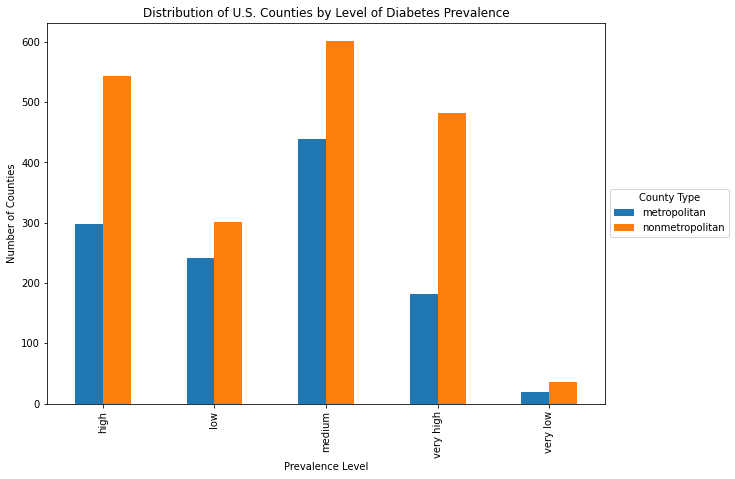

In [142]:
#Make a plot showing distribution by prevalence level
diabetes_prev_df.groupby(['prev_level','metro_nonmetro']).size().unstack().plot(kind='bar',figsize=(10,7))
plt.xlabel('Prevalence Level')
plt.ylabel('Number of Counties')
plt.title('Distribution of U.S. Counties by Level of Diabetes Prevalence')
plt.legend(title='County Type', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Observations:
- In all cases, there is a greater prevalence of diabetes in non-metropolitan counties than metropolitan ones.

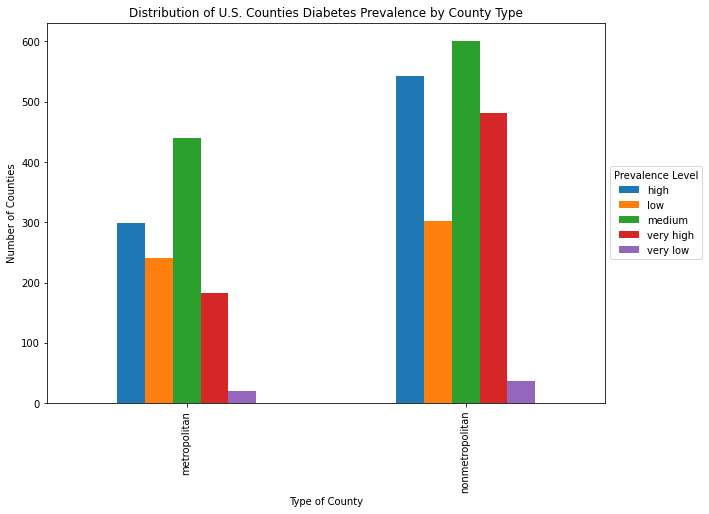

In [144]:
#make a plot of prevalence distribution by county type
prev_levels = diabetes_prev_df.groupby(['metro_nonmetro','prev_level']).size().unstack().plot(kind='bar',figsize=(10,7))
plt.xlabel('Type of County')
plt.ylabel('Number of Counties')
plt.title('Distribution of U.S. Counties Diabetes Prevalence by County Type')
plt.legend(title='Prevalence Level', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Observations:
- Most counties, regardless of what type, have medium level prevalence.
- Non-metropolitan counties are more likely to be higher prevalence.

In [145]:
#create filters to make new data frames and files to be used in further analysis and merging

#prev filter
high_filter = diabetes_prev_df['prev_level'] == 'high'
vhigh_filter = diabetes_prev_df['prev_level'] == 'very high'
med_filter = diabetes_prev_df['prev_level'] == 'medium'
low_filter = diabetes_prev_df['prev_level'] == 'low'
vlow_filter = diabetes_prev_df['prev_level'] == 'very low'

#metro filter
metro_filter = diabetes_prev_df['metro_nonmetro'] == 'metropolitan'
nonmetro_filter = diabetes_prev_df['metro_nonmetro'] == 'nonmetropolitan'

In [146]:
#data frame for metropolitan counties only
metro_prev_df = diabetes_prev_df[metro_filter]
metro_prev_df

,metro_nonmetro,county_name,state_abbr,db_prev,prev_level,prev_colorcode,metro_colorcode
0,metropolitan,anchorage municipality,AK,8.400030,low,green,blue
1,metropolitan,fairbanks north star borough,AK,7.100060,low,green,blue
2,metropolitan,matanuska-susitna borough,AK,8.900071,low,green,blue
3,metropolitan,autauga county,AL,12.700204,high,orange,blue
4,metropolitan,baldwin county,AL,10.300056,medium,yellow,blue
...,...,...,...,...,...,...,...
1175,metropolitan,wayne county,WV,18.600523,very high,red,blue
1176,metropolitan,wirt county,WV,14.500224,high,orange,blue
1177,metropolitan,wood county,WV,18.000061,very high,red,blue
1178,metropolitan,laramie county,WY,9.900025,medium,yellow,blue


In [147]:
#data frame for non-metropolitan counties only
nonmetro_prev_df = diabetes_prev_df[nonmetro_filter]
nonmetro_prev_df

,metro_nonmetro,county_name,state_abbr,db_prev,prev_level,prev_colorcode,metro_colorcode
1180,nonmetropolitan,aleutians east borough,AK,14.503332,high,orange,red
1181,nonmetropolitan,aleutians west census area,AK,7.501003,low,green,red
1182,nonmetropolitan,bethel census area,AK,6.500453,low,green,red
1183,nonmetropolitan,bristol bay borough,AK,17.612809,very high,red,red
1184,nonmetropolitan,denali borough,AK,7.901086,low,green,red
...,...,...,...,...,...,...,...
3139,nonmetropolitan,sweetwater county,WY,8.300101,low,green,red
3140,nonmetropolitan,teton county,WY,2.400087,very low,blue,red
3141,nonmetropolitan,uinta county,WY,10.300429,medium,yellow,red
3142,nonmetropolitan,washakie county,WY,10.700487,medium,yellow,red


In [149]:
#data frame for counties with low prevalence (less than 9%)
low_prev_df = diabetes_prev_df[low_filter | vlow_filter]
low_prev_df

,metro_nonmetro,county_name,state_abbr,db_prev,prev_level,prev_colorcode,metro_colorcode
0,metropolitan,anchorage municipality,AK,8.400030,low,green,blue
1,metropolitan,fairbanks north star borough,AK,7.100060,low,green,blue
2,metropolitan,matanuska-susitna borough,AK,8.900071,low,green,blue
55,metropolitan,coconino county,AZ,7.700018,low,green,blue
56,metropolitan,maricopa county,AZ,8.700003,low,green,blue
...,...,...,...,...,...,...,...
3134,nonmetropolitan,niobrara county,WY,8.200103,low,green,red
3135,nonmetropolitan,park county,WY,8.900219,low,green,red
3137,nonmetropolitan,sheridan county,WY,8.700035,low,green,red
3139,nonmetropolitan,sweetwater county,WY,8.300101,low,green,red


In [150]:
#save as a new file for further analysis in subsequent notebook
low_prev_df.to_csv('../data/low_db_prev.csv', index=False)

In [151]:
#data frame for counties with a high prevalence (more than 12%)
high_prev_df = diabetes_prev_df[high_filter | vhigh_filter]
high_prev_df

,metro_nonmetro,county_name,state_abbr,db_prev,prev_level,prev_colorcode,metro_colorcode
3,metropolitan,autauga county,AL,12.700204,high,orange,blue
5,metropolitan,bibb county,AL,13.600642,high,orange,blue
6,metropolitan,blount county,AL,14.600135,high,orange,blue
7,metropolitan,calhoun county,AL,17.000104,very high,red,blue
8,metropolitan,chilton county,AL,19.000031,very high,red,blue
...,...,...,...,...,...,...,...
3121,nonmetropolitan,wetzel county,WV,19.400998,very high,red,red
3122,nonmetropolitan,wyoming county,WV,15.900696,very high,red,red
3124,nonmetropolitan,big horn county,WY,14.400186,high,orange,red
3131,nonmetropolitan,hot springs county,WY,12.101911,high,orange,red


In [152]:
#save as a new file for further analysis in subsequent notebook
high_prev_df.to_csv('../data/high_db_prev.csv', index=False)

In [153]:
#data frame for counties with medium level prevalence (9 to 12%)
med_prev_df = diabetes_prev_df[med_filter]
med_prev_df

,metro_nonmetro,county_name,state_abbr,db_prev,prev_level,prev_colorcode,metro_colorcode
4,metropolitan,baldwin county,AL,10.300056,medium,yellow,blue
20,metropolitan,lee county,AL,10.300029,medium,yellow,blue
29,metropolitan,shelby county,AL,10.500051,medium,yellow,blue
33,metropolitan,benton county,AR,9.600004,medium,yellow,blue
38,metropolitan,faulkner county,AR,10.400071,medium,yellow,blue
...,...,...,...,...,...,...,...
3133,nonmetropolitan,lincoln county,WY,9.200293,medium,yellow,red
3138,nonmetropolitan,sublette county,WY,10.401088,medium,yellow,red
3141,nonmetropolitan,uinta county,WY,10.300429,medium,yellow,red
3142,nonmetropolitan,washakie county,WY,10.700487,medium,yellow,red


In [154]:
#save as a new file for further analysis in subsequent notebook
med_prev_df.to_csv('../data/med_db_prev.csv', index=False)

## For personal interest, looking at my own county data.

In [155]:
#bergen county filter
bergen_filter = diabetes_prev_df['county_name'] == 'bergen county'

In [156]:
#bergen county data frame
bergen_df = diabetes_prev_df[bergen_filter]
bergen_df

,metro_nonmetro,county_name,state_abbr,db_prev,prev_level,prev_colorcode,metro_colorcode
678,metropolitan,bergen county,NJ,8.7,low,green,blue


## Next step

The files created in this notebook will be connected to state data about life expectancy, mortalaity rate, and popuand data about counties' income, education level, employment, and insurance coverage in the following notebooks.